In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [504]:
df = pd.read_csv("data/bicikelj_train.csv")
df = df.set_index("timestamp")
df.index = pd.to_datetime(df.index)

# Round the index to the nearest 5 minuter interval ignoring seconds
df.index = df.index.round("5min")

# Where there are duplicate indexes subtract 5 minutes from the first instance
df.index = df.index.where(~df.index.duplicated(keep="first"), df.index - pd.Timedelta(minutes=5))

# Check if there are duplicate index values
display(df.index.has_duplicates)

# Count the number of duplicate index values
display(df.index.duplicated().sum())

# Find the duplicate index values
display(df.index[df.index.duplicated()])

display(df.tail())
display(df.info())

True

36

DatetimeIndex(['2022-08-03 00:35:00', '2022-08-03 00:45:00',
               '2022-08-03 00:55:00', '2022-08-07 14:05:00',
               '2022-08-07 16:05:00', '2022-08-07 17:05:00',
               '2022-08-11 13:20:00', '2022-08-11 13:40:00',
               '2022-08-14 03:20:00', '2022-08-14 08:10:00',
               '2022-08-14 09:10:00', '2022-08-14 10:20:00',
               '2022-08-18 07:55:00', '2022-08-18 08:00:00',
               '2022-08-23 22:50:00', '2022-09-08 05:00:00',
               '2022-09-15 12:20:00', '2022-09-16 01:20:00',
               '2022-09-16 04:20:00', '2022-09-16 05:30:00',
               '2022-09-16 06:40:00', '2022-09-16 09:20:00',
               '2022-09-16 09:40:00', '2022-09-16 10:50:00',
               '2022-09-20 09:05:00', '2022-09-20 09:55:00',
               '2022-09-20 10:15:00', '2022-09-20 10:35:00',
               '2022-09-28 01:35:00', '2022-09-28 05:15:00',
               '2022-09-28 09:45:00', '2022-09-28 10:05:00',
               '2022-09-

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,POGAČARJEV TRG-TRŽNICA,KONGRESNI TRG-ŠUBIČEVA ULICA,CANKARJEVA UL.-NAMA,BREG,GRUDNOVO NABREŽJE-KARLOVŠKA C.,MIKLOŠIČEV PARK,BAVARSKI DVOR,TRG OF-KOLODVORSKA UL.,MASARYKOVA DDC,...,POVŠETOVA - KAJUHOVA,SOSESKA NOVO BRDO,TEHNOLOŠKI PARK,VOJKOVA - GASILSKA BRIGADA,GERBIČEVA - ŠPORTNI PARK SVOBODA,DOLENJSKA C. - STRELIŠČE,ROŠKA - STRELIŠKA,LEK - VEROVŠKOVA,VOKA - SLOVENČEVA,SUPERNOVA LJUBLJANA - RUDNIK
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-01 18:05:00,18,17,14,7,7,5,10,20,25,4,...,18,3,8,3,2,17,13,13,11,7
2022-10-01 18:00:00,20,17,13,7,7,5,11,19,24,4,...,18,2,8,3,2,17,13,13,11,7
2022-10-01 18:15:00,19,18,14,5,8,3,10,20,23,5,...,17,3,8,2,2,17,13,13,11,7
2022-10-01 18:10:00,19,17,16,4,6,3,9,17,21,5,...,17,3,8,1,1,17,13,13,11,7
2022-10-01 18:25:00,20,17,15,3,6,6,9,16,21,5,...,17,3,8,2,1,19,13,13,11,7


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7739 entries, 2022-08-02 13:05:00 to 2022-10-01 18:25:00
Data columns (total 83 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    7739 non-null   int64
 1   POGAČARJEV TRG-TRŽNICA                7739 non-null   int64
 2   KONGRESNI TRG-ŠUBIČEVA ULICA          7739 non-null   int64
 3   CANKARJEVA UL.-NAMA                   7739 non-null   int64
 4   BREG                                  7739 non-null   int64
 5   GRUDNOVO NABREŽJE-KARLOVŠKA C.        7739 non-null   int64
 6   MIKLOŠIČEV PARK                       7739 non-null   int64
 7   BAVARSKI DVOR                         7739 non-null   int64
 8   TRG OF-KOLODVORSKA UL.                7739 non-null   int64
 9   MASARYKOVA DDC                        7739 non-null   int64
 10  VILHARJEVA CESTA                      7739 non-null   int64
 11  PARK NA

None

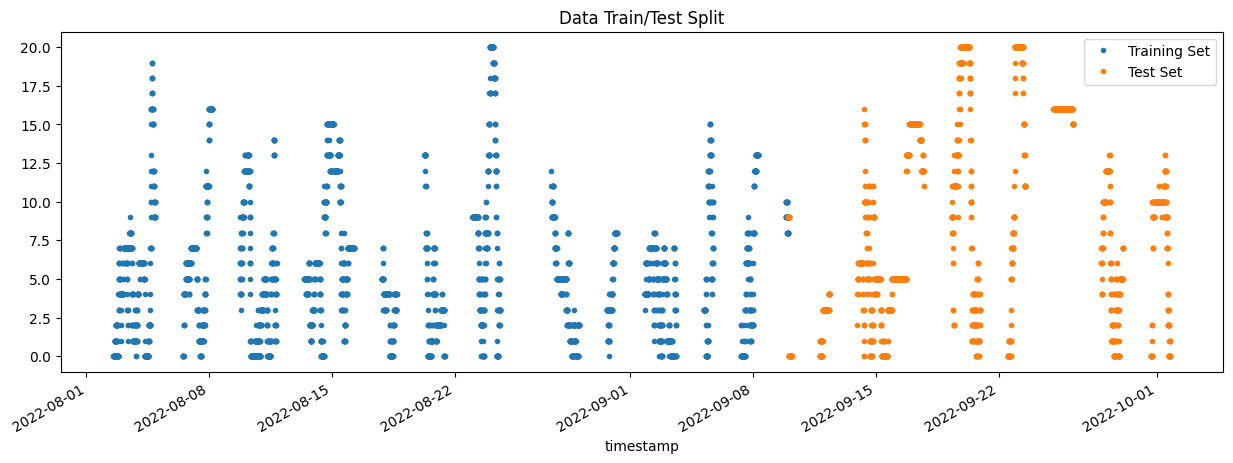

In [505]:
# For the sake of simplicity, I will only use the timestamp and the "CESTA NA ROŽNIK" station
df_simple = df[["CESTA NA ROŽNIK"]]

train = df_simple.loc[df.index < '2022-09-10']
test = df_simple.loc[df.index >= '2022-09-10']

ig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', style=".")
test.plot(ax=ax, label='Test Set', style=".")
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Time Series Cross Validation

In [506]:
tss = TimeSeriesSplit(n_splits=5, gap=(60 // 5))
df_simple = df_simple.sort_index()

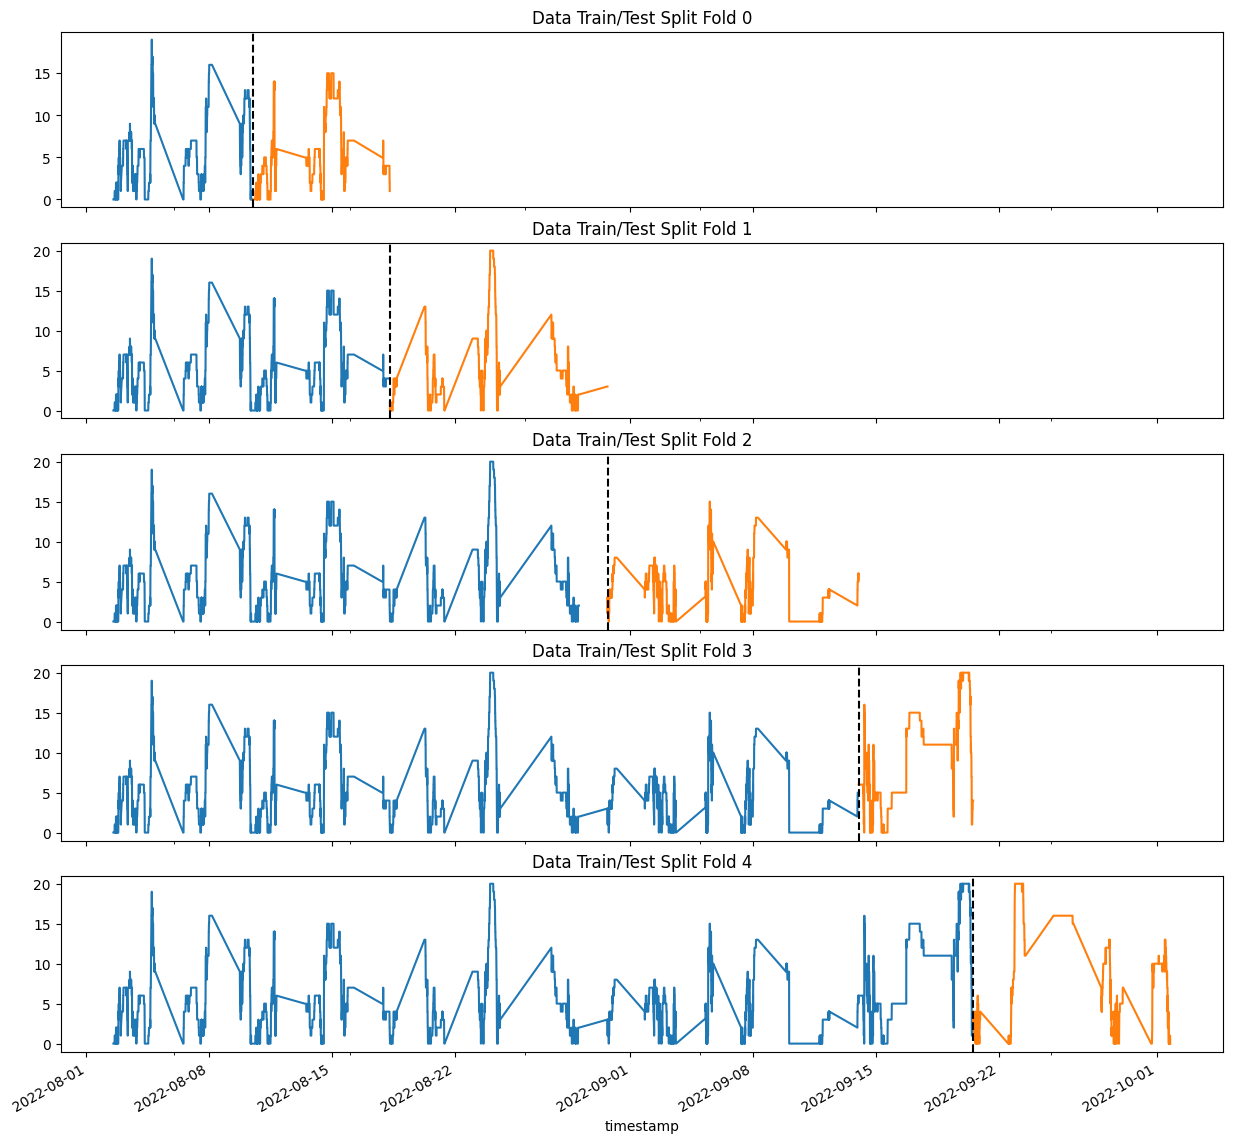

In [507]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_simple):
    train = df_simple.iloc[train_idx]
    test = df_simple.iloc[val_idx]
    train['CESTA NA ROŽNIK'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['CESTA NA ROŽNIK'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Feature creation

In [508]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df_simple = create_features(df_simple)
df_simple.head()

,CESTA NA ROŽNIK,hour,dayofweek,month,dayofyear,dayofmonth
timestamp,,,,,,
2022-08-02 13:05:00,0,13,1,8,214,2
2022-08-02 13:10:00,0,13,1,8,214,2
2022-08-02 13:15:00,0,13,1,8,214,2
2022-08-02 13:20:00,0,13,1,8,214,2
2022-08-02 13:25:00,0,13,1,8,214,2


In [509]:
def add_lags(df):
    df = df.copy()
    target_map = df['CESTA NA ROŽNIK'].to_dict()

    # Create a lag feature by getting the value of the target variable 60 minutes before
    df['lag1'] = (df.index - pd.Timedelta('60 minutes')).map(target_map)
    # Fill in missing values with the value of the next of previous feature
    df["lag1"] = df["lag1"].fillna(df["lag1"].shift(1)).fillna(df["lag1"].shift(-1))
    # If there are still missing values fill them with the mean value of 6 surrounding values
    df["lag1"] = df["lag1"].fillna(df["lag1"].rolling(7, min_periods=1, center=True).mean()).round(0).astype("Int64") #.median() ?
    df["lag1"] = df["lag1"].fillna(df["lag1"].shift(1)).fillna(df["lag1"].shift(-1))
    # The same process for 90 minutes nad 120 minutes
    df['lag2'] = (df.index - pd.Timedelta('90 minutes')).map(target_map)
    df["lag2"] = df["lag2"].fillna(df["lag2"].shift(1)).fillna(df["lag2"].shift(-1))
    df["lag2"] = df["lag2"].fillna(df["lag2"].rolling(7, min_periods=1, center=True).mean()).round(0).astype("Int64")
    df["lag2"] = df["lag2"].fillna(df["lag2"].shift(1)).fillna(df["lag2"].shift(-1))
    df['lag3'] = (df.index - pd.Timedelta('120 minutes')).map(target_map)
    df["lag3"] = df["lag3"].fillna(df["lag3"].shift(1)).fillna(df["lag3"].shift(-1))
    df["lag3"] = df["lag3"].fillna(df["lag3"].rolling(7, min_periods=1, center=True).mean()).round(0).astype("Int64")
    df["lag3"] = df["lag3"].fillna(df["lag3"].shift(1)).fillna(df["lag3"].shift(-1))

    return df

df_simple = add_lags(df_simple)
display(df_simple.tail())
display(df_simple.isna().sum())
display(df_simple.head(20))

,CESTA NA ROŽNIK,hour,dayofweek,month,dayofyear,dayofmonth,lag1,lag2,lag3
timestamp,,,,,,,,,
2022-10-01 18:00:00,1,18,5,10,274,1,0.0,0.0,4.0
2022-10-01 18:05:00,1,18,5,10,274,1,0.0,2.0,3.0
2022-10-01 18:10:00,1,18,5,10,274,1,0.0,0.0,3.0
2022-10-01 18:15:00,1,18,5,10,274,1,0.0,0.0,2.0
2022-10-01 18:25:00,0,18,5,10,274,1,0.0,0.0,2.0


CESTA NA ROŽNIK      0
hour                 0
dayofweek            0
month                0
dayofyear            0
dayofmonth           0
lag1                40
lag2               152
lag3               262
dtype: int64

,CESTA NA ROŽNIK,hour,dayofweek,month,dayofyear,dayofmonth,lag1,lag2,lag3
timestamp,,,,,,,,,
2022-08-02 13:05:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:10:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:15:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:20:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:25:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:30:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:35:00,0,13,1,8,214,2,NaN,NaN,NaN
2022-08-02 13:40:00,0,13,1,8,214,2,0.0,NaN,NaN
2022-08-02 13:45:00,0,13,1,8,214,2,0.0,NaN,NaN


In [510]:
tss = TimeSeriesSplit(n_splits=5, gap=(60 // 5))
df_simple = df_simple.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_simple):
    train = df_simple.iloc[train_idx]
    test = df_simple.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'month', 'dayofyear', 'dayofmonth',
                'lag1','lag2','lag3']
    TARGET = 'CESTA NA ROŽNIK'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:absoluteerror',
                           max_depth=3,
                           learning_rate=0.1)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_error(y_test, y_pred)
    scores.append(score)

[0]	validation_0-mae:5.38559	validation_1-mae:5.13772
[100]	validation_0-mae:1.38445	validation_1-mae:2.00908
[170]	validation_0-mae:0.90683	validation_1-mae:1.97758
[0]	validation_0-mae:5.25267	validation_1-mae:5.05964
[100]	validation_0-mae:1.47952	validation_1-mae:2.28285
[200]	validation_0-mae:0.97181	validation_1-mae:1.98729
[289]	validation_0-mae:0.92848	validation_1-mae:1.94281
[0]	validation_0-mae:5.19115	validation_1-mae:4.07274
[100]	validation_0-mae:1.62358	validation_1-mae:1.87977
[197]	validation_0-mae:1.10222	validation_1-mae:1.77434
[0]	validation_0-mae:4.90373	validation_1-mae:8.50533
[100]	validation_0-mae:1.60987	validation_1-mae:5.33229
[200]	validation_0-mae:1.20634	validation_1-mae:3.71877
[267]	validation_0-mae:1.16151	validation_1-mae:3.72835
[0]	validation_0-mae:5.62849	validation_1-mae:9.44910
[100]	validation_0-mae:1.87311	validation_1-mae:3.94155
[200]	validation_0-mae:1.17955	validation_1-mae:2.90688
[217]	validation_0-mae:1.15709	validation_1-mae:2.87351


In [511]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.3036
Fold scores:[1.9070037029932134, 1.915126230027252, 1.760184305966409, 3.663530422699738, 2.2721849934911806]


In [512]:
df_simple = create_features(df_simple)

FEATURES = ['hour', 'dayofweek', 'month', 'dayofyear', 'dayofmonth',
            'lag1','lag2','lag3']
TARGET = 'CESTA NA ROŽNIK'

X_all = df_simple[FEATURES]
y_all = df_simple[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:absoluteerror',
                           max_depth=3,
                           learning_rate=0.1)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-mae:6.25984
[100]	validation_0-mae:2.11978
[200]	validation_0-mae:1.18127
[300]	validation_0-mae:1.12762
[400]	validation_0-mae:1.10435
[500]	validation_0-mae:1.10201
[600]	validation_0-mae:1.09173
[700]	validation_0-mae:1.08213
[800]	validation_0-mae:1.07123
[900]	validation_0-mae:1.06638
[999]	validation_0-mae:1.05927


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:absoluteerror', predictor=None, ...)

In [513]:
df_test = pd.read_csv("data/bicikelj_test.csv")
df_test = df_test.set_index("timestamp")
df_test.index = pd.to_datetime(df_test.index)

# Concatenate the two dataframes, so we can use the add_lags function which uses data from the past which is in the training set
df_test["Test"] = True
df["Test"] = False
test_and_train = pd.concat([df, df_test])
test_and_train = test_and_train.sort_index()

# Select only the "CESTA NA ROŽNIK" station and create features
test_and_train = test_and_train[["CESTA NA ROŽNIK", "Test"]]
test_and_train = create_features(test_and_train)
test_and_train = add_lags(test_and_train)

# Select only the rows which are in the test set
df_test_w_features = test_and_train[test_and_train["Test"] == True]

# Number of rows with NaN values
df_test_w_features.isna().sum()


CESTA NA ROŽNIK    40
Test                0
hour                0
dayofweek           0
month               0
dayofyear           0
dayofmonth          0
lag1                0
lag2                0
lag3                0
dtype: int64

C:\Users\zanme\AppData\Local\Temp\ipykernel_7024\3720556320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_w_features["pred"] = reg.predict(df_test_w_features[FEATURES])


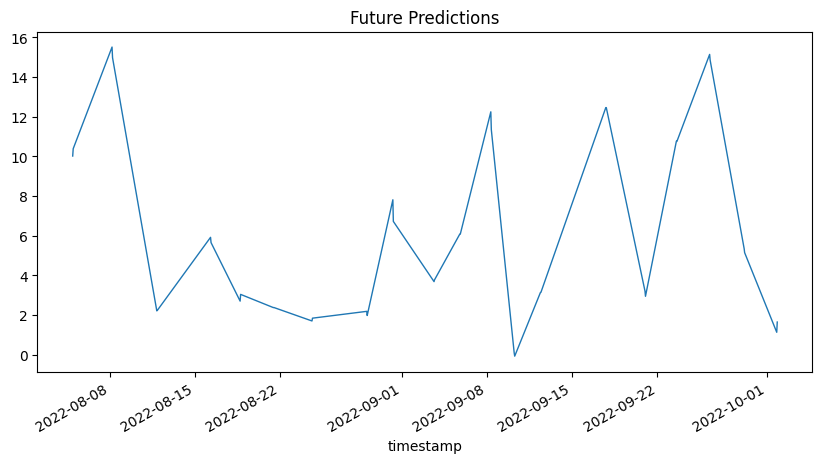

In [514]:
# Predict the values
df_test_w_features["pred"] = reg.predict(df_test_w_features[FEATURES])

df_test_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()